### Stacked model

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import confinement_mode_classifier as cmc
from datetime import datetime
import time 
import torchvision
import torch
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Seed set to 42


Device: cuda:0


In [2]:

batch_size = 16
shots = [16534, 16769, 16773, 18130, 19237, 19240, 19379, 18057, 16989]
shots_for_testing = [16769, 18130, 18057]
shots_for_validation = [19237]


shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path,shots, shots_for_testing, shots_for_validation, use_ELMS=False)

test_dataloader = cmc.get_two_imgs_dloader(test_df, path=path, batch_size=batch_size,
                                   shuffle=False, balance_data=True, second_img_opt='prev')

val_dataloader = cmc.get_two_imgs_dloader(val_df, path=path, batch_size=batch_size,
                                   shuffle=False, balance_data=True, second_img_opt='prev')

train_dataloader = cmc.get_two_imgs_dloader(train_df, path=path, batch_size=batch_size,
                                   shuffle=False, balance_data=True, second_img_opt='prev')

dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

In [3]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1', )
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM
pretrained_model = pretrained_model.to(device)

pretrained_model.load_state_dict(torch.load(f'{path}/runs/14-12-2023, 13-18-26 Compairing frozen and unfrozen models/model_fully_trained.pt'))

untrained_ensembled_model = cmc.TwoImagesModel(modelA=pretrained_model, modelB=pretrained_model, hidden_units=30).to(device)

In [4]:
for name, param in untrained_ensembled_model.named_parameters():
    # Check if the current parameter is part of the MLP
    if 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Verify that only the MLP parameters have requires_grad set to True
for name, param in untrained_ensembled_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

no_fc_modelA.conv1.weight: requires_grad = False
no_fc_modelA.bn1.weight: requires_grad = False
no_fc_modelA.bn1.bias: requires_grad = False
no_fc_modelA.layer1.0.conv1.weight: requires_grad = False
no_fc_modelA.layer1.0.bn1.weight: requires_grad = False
no_fc_modelA.layer1.0.bn1.bias: requires_grad = False
no_fc_modelA.layer1.0.conv2.weight: requires_grad = False
no_fc_modelA.layer1.0.bn2.weight: requires_grad = False
no_fc_modelA.layer1.0.bn2.bias: requires_grad = False
no_fc_modelA.layer1.1.conv1.weight: requires_grad = False
no_fc_modelA.layer1.1.bn1.weight: requires_grad = False
no_fc_modelA.layer1.1.bn1.bias: requires_grad = False
no_fc_modelA.layer1.1.conv2.weight: requires_grad = False
no_fc_modelA.layer1.1.bn2.weight: requires_grad = False
no_fc_modelA.layer1.1.bn2.bias: requires_grad = False
no_fc_modelA.layer2.0.conv1.weight: requires_grad = False
no_fc_modelA.layer2.0.bn1.weight: requires_grad = False
no_fc_modelA.layer2.0.bn1.bias: requires_grad = False
no_fc_modelA.layer2

In [5]:
timestamp =  datetime.fromtimestamp(time.time()).strftime("%d-%m-%Y, %H-%M-%S ") + input('add comment: ')

# create grid of images
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{timestamp}')

In [6]:
#
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001) #pouzit adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 2

ensembled_model = cmc.train_model(untrained_ensembled_model, criterion, optimizer, exp_lr_scheduler, 
                       dataloaders, writer, dataset_sizes, num_epochs=num_epochs, comment = 'MLP training')

Epoch 1/2
----------


  0%|          | 0/560 [00:00<?, ?it/s]

train Loss: 1.1999 Acc: 0.4958


  0%|          | 0/122 [00:00<?, ?it/s]

val Loss: 1.1593 Acc: 0.4913

Epoch 2/2
----------


  0%|          | 0/560 [00:00<?, ?it/s]

train Loss: 1.2020 Acc: 0.4895


  0%|          | 0/122 [00:00<?, ?it/s]

val Loss: 1.1553 Acc: 0.5031

Training complete in 11m 16s
Best val Acc: 0.503074


Processing batches:   0%|          | 0/393 [00:00<?, ?it/s]

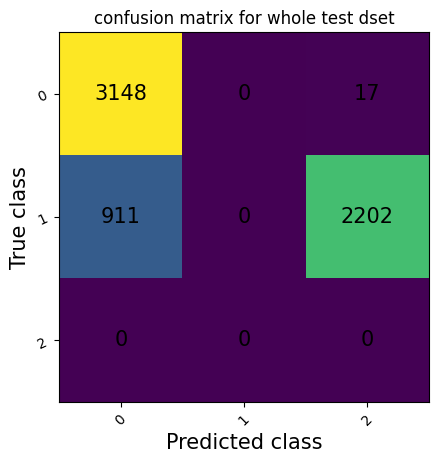

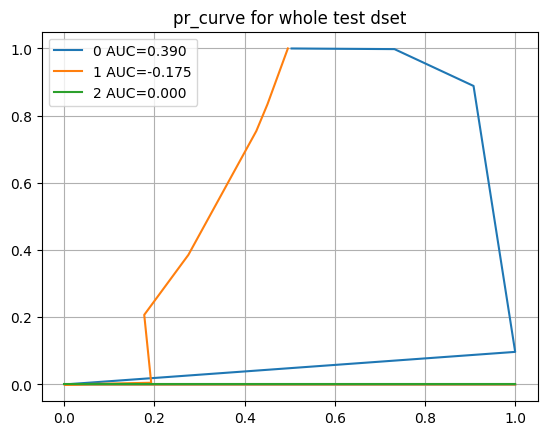

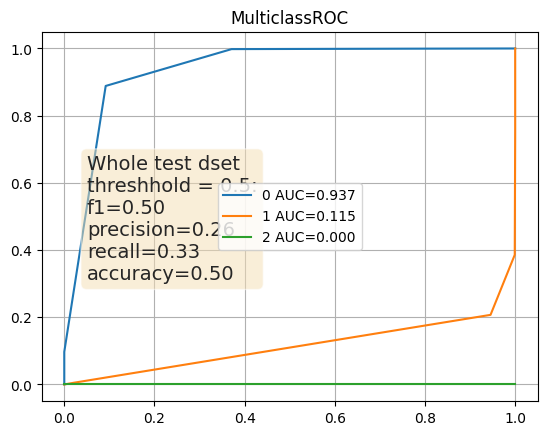

In [7]:

predictions_df, fig_confusion_matrix, f1, precision, recall, accuracy, pr_curve, roc_curve = cmc.test_model(f'runs/{timestamp}', ensembled_model, test_dataloader)

In [8]:
model_path = Path(f'runs/{timestamp}/two_subseq_imgs_model.pt')
torch.save(ensembled_model.state_dict(), model_path)